In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_dir = '/content/drive/MyDrive/Seg_UKAN/inputs/busi/busi/images'
mask_dir = '/content/drive/MyDrive/Seg_UKAN/inputs/busi/busi/masks/0'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

class NestedUNet(nn.Module):
    def __init__(self, num_classes=1, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]
        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return torch.sigmoid(output)  # Sigmoid activation for binary segmentation




In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),
])

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".png", "_mask.png"))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# Load the dataset
dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)

# Split such that first 42 images are in validation, and the rest in training
val_size = 42
train_set = torch.utils.data.Subset(dataset, list(range(val_size, len(dataset))))
val_set = torch.utils.data.Subset(dataset, list(range(0,41)))

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

# Define device, model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NestedUNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader)}")
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

        print(f"Validation Loss: {val_loss / len(val_loader)}")

Epoch [1/100], Loss: 0.8772872686386108
Validation Loss: 0.9110816220442454
Epoch [2/100], Loss: 0.8378396743819827
Validation Loss: 0.8331651190916697
Epoch [3/100], Loss: 0.8227306831450689
Validation Loss: 0.8586114744345347
Epoch [4/100], Loss: 0.8145597151347569
Validation Loss: 0.816858152548472
Epoch [5/100], Loss: 0.8099397392500014
Validation Loss: 0.8067758083343506
Epoch [6/100], Loss: 0.8050195404461452
Validation Loss: 0.817118505636851
Epoch [7/100], Loss: 0.802183327220735
Validation Loss: 0.7981317540009817
Epoch [8/100], Loss: 0.7961370746294657
Validation Loss: 0.7987553675969442
Epoch [9/100], Loss: 0.7909402222860427
Validation Loss: 0.7942278583844503
Epoch [10/100], Loss: 0.7868060895374843
Validation Loss: 0.7920245925585429
Epoch [11/100], Loss: 0.7829085645221528
Validation Loss: 0.7894178926944733
Epoch [12/100], Loss: 0.7789361022767567
Validation Loss: 0.7922107974688212
Epoch [13/100], Loss: 0.7751636845724923
Validation Loss: 0.7849481304486593
Epoch [14/1

In [ ]:
def calculate_continuous_metrics(y_true, y_pred, epsilon=1e-6):
    # Flatten the arrays for metric calculation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Intersection and Union for continuous IoU
    intersection = np.sum(np.minimum(y_true_flat, y_pred_flat))
    union = np.sum(np.maximum(y_true_flat, y_pred_flat))

    iou = (intersection + epsilon) / (union + epsilon)  # Add epsilon to avoid division by zero

    # Continuous F1 score (soft F1)
    true_positives = np.sum(y_true_flat * y_pred_flat)
    precision = true_positives / (np.sum(y_pred_flat) + epsilon)
    recall = true_positives / (np.sum(y_true_flat) + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    return iou, f1


In [ ]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        outputs = outputs.cpu().numpy()
        masks = masks.cpu().numpy()

        y_true.append(masks)
        y_pred.append(outputs)

# Concatenate all predictions and true masks
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Apply a threshold to convert the continuous predictions to binary
y_pred_thresholded = (y_pred > 0.5).astype(np.float32)

# Now calculate IoU and F1 scores using the thresholded predictions
iou, f1 = calculate_continuous_metrics(y_true, y_pred_thresholded)
print(f"IoU: {iou:.4f}, F1 Score: {f1:.4f}")


IoU: 0.6191, F1 Score: 0.7648


In [ ]:
output_dir='/content/drive/MyDrive/busi_nested_output'
for idx in range(y_pred_thresholded.shape[0]):
    pred_mask = y_pred_thresholded[idx, 0]  # Extract the predicted mask (single channel)
    pred_mask = (pred_mask * 255).astype(np.uint8)  # Scale to 0-255

    # Save the mask image
    img_save_path = os.path.join(output_dir, f"segmented_{idx}.png")
    cv2.imwrite(img_save_path, pred_mask)

print(f"Segmented images saved in {output_dir}")

Segmented images saved in /content/drive/MyDrive/busi_nested_output


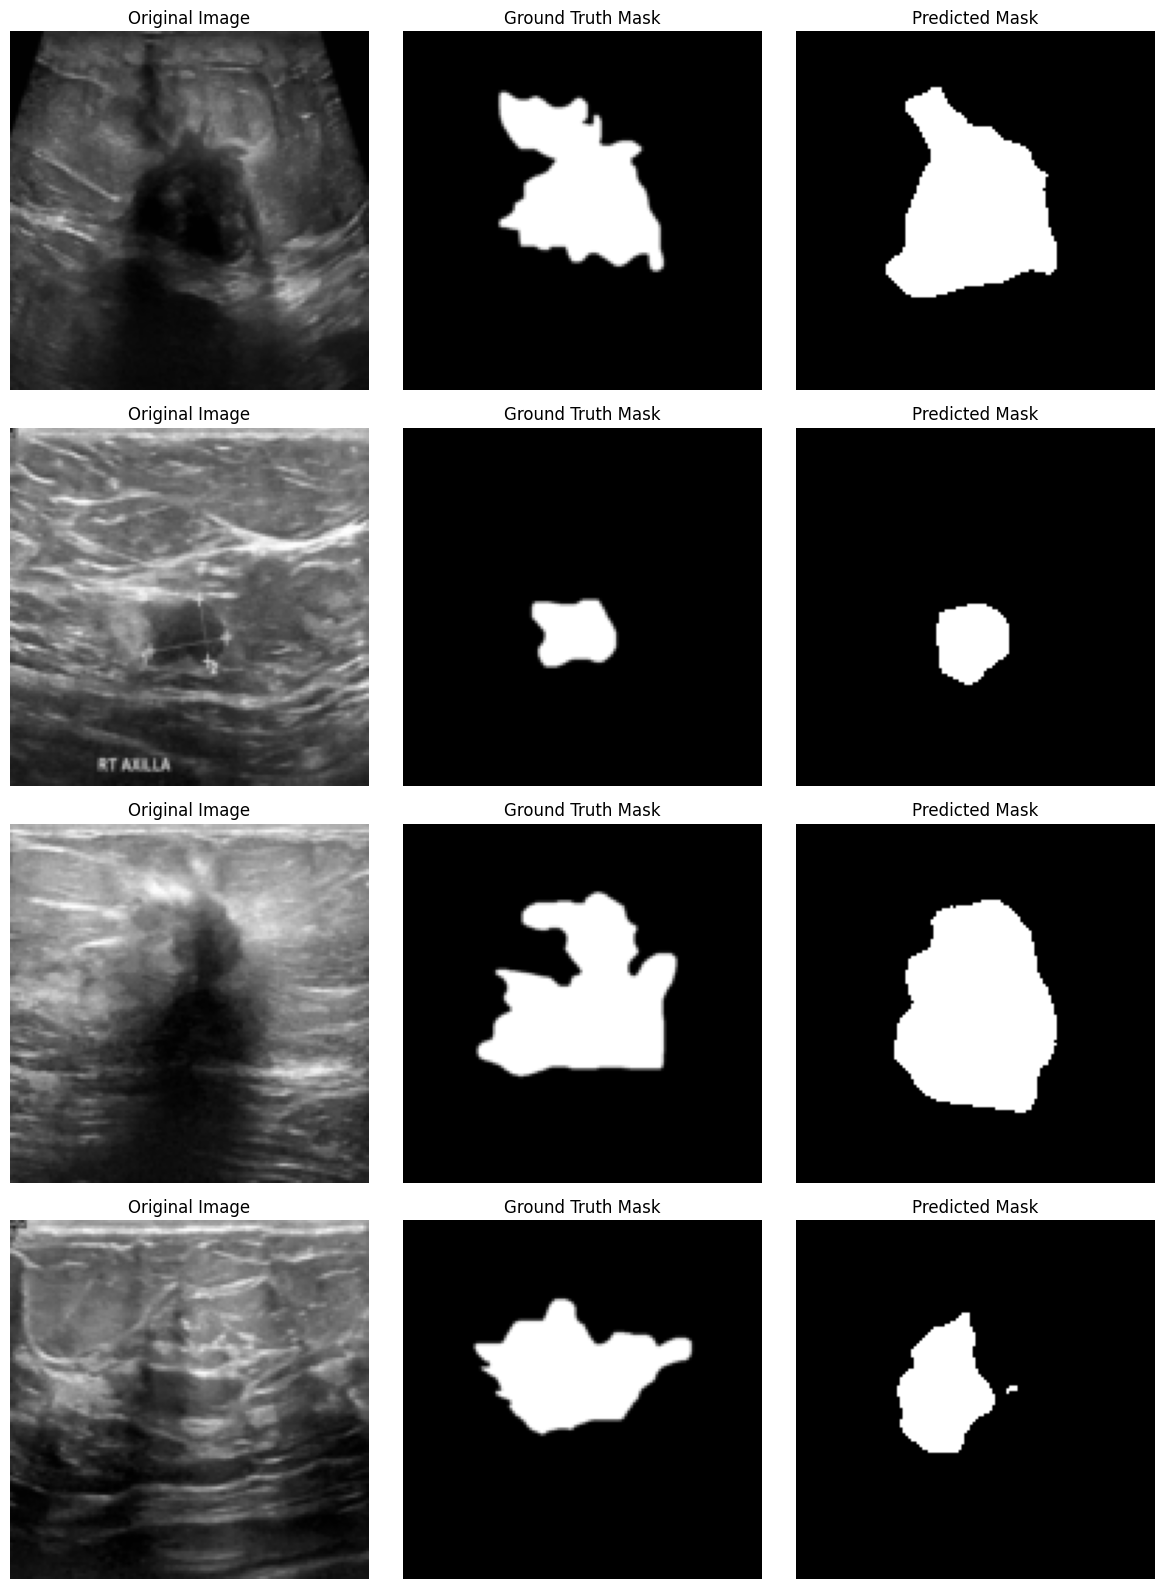

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(images, true_masks, predicted_masks, num_samples=4):
    plt.figure(figsize=(12, num_samples * 4))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))  # Convert image tensor to HxWxC format
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(true_masks[i][0], cmap='gray')  # Display the first channel of the mask
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predicted_masks[i][0], cmap='gray')  # Display the first channel of the predicted mask
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Get a batch from the validation loader and plot
model.eval()
with torch.no_grad():
    images, true_masks = next(iter(val_loader))  # Get a batch of validation data
    images = images.to(device)

    # Predict the masks
    predicted_masks = model(images).cpu().numpy()

    # Convert true masks to CPU and apply threshold to predicted masks
    true_masks = true_masks.cpu().numpy()
    predicted_masks_thresholded = (predicted_masks > 0.5).astype(np.float32)

    # Visualize the first few samples
    visualize_predictions(images, true_masks, predicted_masks_thresholded, num_samples=4)


In [ ]:
import os
import torch
import numpy as np
import cv2
from torch.utils.data import DataLoader

# Define the output directory for saving segmented images
output_dir = '/content/drive/MyDrive/busi_nested_output'
os.makedirs(output_dir, exist_ok=True)

# Load the entire dataset (no train/validation split for segmentation)
full_loader = DataLoader(dataset, batch_size=4, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Iterate through the entire dataset and predict masks
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(full_loader):
        images = images.to(device)

        # Get model predictions
        outputs = model(images)
        outputs = outputs.cpu().numpy()

        # Apply a threshold to convert the continuous predictions to binary
        y_pred_thresholded = (outputs > 0.5).astype(np.float32)

        # Save each predicted mask
        for idx in range(y_pred_thresholded.shape[0]):
            pred_mask = y_pred_thresholded[idx, 0]  # Extract the predicted mask (single channel)
            pred_mask = (pred_mask * 255).astype(np.uint8)  # Scale to 0-255

            # Save the mask image
            img_save_path = os.path.join(output_dir, f"segmented_{batch_idx * full_loader.batch_size + idx}.png")
            cv2.imwrite(img_save_path, pred_mask)

# Notify when done
print(f"Segmented images saved in {output_dir}")


Segmented images saved in /content/drive/MyDrive/busi_nested_output
